In [1]:
from t2_flujo import *
import folium
import matplotlib.pyplot as plt
import funciones
import parametros
import csv

# Mapa

In [2]:
north = -41.4
south = -41.496
east = -72.8
west = -73.03

PM = ox.graph_from_bbox(north,south,east,west,network_type='drive')

In [3]:
duplicados = []

for u,v,a in PM.edges(data = True):
  if len(PM[u][v]) == 2:
    duplicados.append((u,v,1))
  elif len(PM[u][v]) == 3:
    duplicados.append((u,v,1))
    duplicados.append((u,v,2))


duplicados = list(dict.fromkeys(duplicados))
PM.remove_edges_from(duplicados)

In [4]:
def setear(filename):
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Omitir el encabezado, si existe
        coordenadas = [tuple(map(float, row[1:3])) for row in reader]
    return coordenadas

In [5]:
coordenadas_plantas = setear('datos/ubicacion_produccion.csv')
coordenadas_almacenes = setear('datos/ubicacion_demanda.csv')
coordenadas_bodegas = setear('datos/ubicacion_bodegas_adicionales.csv')

print (coordenadas_plantas)
print(coordenadas_almacenes)
print(coordenadas_bodegas)

[(-72.9049847, -41.4382097), (-72.89773, -41.4616118), (-73.0018052, -41.4748112), (-72.9806647, -41.4723745), (-72.9569328, -41.4269752), (-72.886137, -41.4280949), (-72.9125495, -41.4548131)]
[(-72.9180463, -41.4723684), (-72.9469427, -41.4568804), (-72.9942386, -41.4478807), (-72.9723534, -41.4658041), (-72.9047511, -41.4556736), (-72.989895, -41.478831), (-72.9365376, -41.465138), (-72.9793107, -41.470842), (-72.9192027, -41.4598745), (-72.9708642, -41.4873284), (-72.9229513, -41.4737758), (-72.9237241, -41.4616888), (-72.9144487, -41.4744047), (-72.9690185, -41.4795911), (-72.9703678, -41.4669273), (-72.9420883, -41.4560195), (-72.9723474, -41.4671811), (-72.9100943, -41.4596985), (-72.9988203, -41.4658013), (-72.9911929, -41.4441747), (-72.9113151, -41.4222032), (-72.9172653, -41.4616971), (-72.9911983, -41.4790814), (-72.9037715, -41.4110034)]
[(-72.995677, -41.4626411), (-72.9575967, -41.4735434), (-72.9709703, -41.46606), (-72.9214348, -41.4473181), (-72.9017258, -41.4044988),

In [6]:
def buscar_nodo(grafo, lista_coords):
    nodos = []
    for ubicacion in lista_coords:
        x = ubicacion[0]
        y = ubicacion[1]
        nodo_cercano = ox.nearest_nodes(grafo, x, y)
        nodos.append(nodo_cercano)
    return nodos

In [7]:
n_plantas = buscar_nodo(PM, coordenadas_plantas)
n_almacenes = buscar_nodo(PM, coordenadas_almacenes)
n_bodegas = buscar_nodo(PM, coordenadas_bodegas)

print("Nodos plantas:", n_plantas)
print("Nodos almacenes:", n_almacenes)
print("Nodos bodegas:", n_bodegas)

Nodos plantas: [10827367167, 7564594729, 12119644005, 475560866, 1143298979, 3723703649, 1853718397]
Nodos almacenes: [9261244985, 265016378, 7832735376, 1886717431, 455782369, 476023196, 9569434781, 475560947, 6107982164, 475560777, 267183037, 266902436, 267182640, 476023935, 267456834, 262503262, 8856840317, 266105475, 1784870488, 1840721441, 3663848976, 266907565, 476023188, 1886787603]
Nodos bodegas: [1784870456, 267187616, 1886717444, 321004778, 1893185450, 9476649431, 265325294, 265742684, 9231325097, 3666343193, 4477723612, 3674253932, 4464073565, 7564594723, 1860972990, 3298590271, 476028433, 475563482]


In [8]:
plantas = []

for i in range(len(n_plantas)):
  plantas.append('planta' + str(i+1))


almacenes = []

for i in range(len(n_almacenes)):
  almacenes.append('almacén' + str(i+1))


bodegas = []

for i in range(len(n_bodegas)):
  bodegas.append('bodega' + str(i+1))



In [9]:
for node_id, nuevo_nombre in zip(n_plantas, plantas):
    if node_id in PM.nodes:
        PM.nodes[node_id]['name'] = nuevo_nombre
    else:
        print(f"Nodo {node_id} de planta no encontrado en el grafo")

for node_id, nuevo_nombre in zip(n_almacenes, almacenes):
    if node_id in PM.nodes:
        PM.nodes[node_id]['name'] = nuevo_nombre
    else:
        print(f"Nodo {node_id} de almacén no encontrado en el grafo")

for node_id, nuevo_nombre in zip(n_bodegas, bodegas):
    if node_id in PM.nodes:
        PM.nodes[node_id]['name'] = nuevo_nombre
    else:
        print(f"Nodo {node_id} de bodega no encontrado en el grafo")

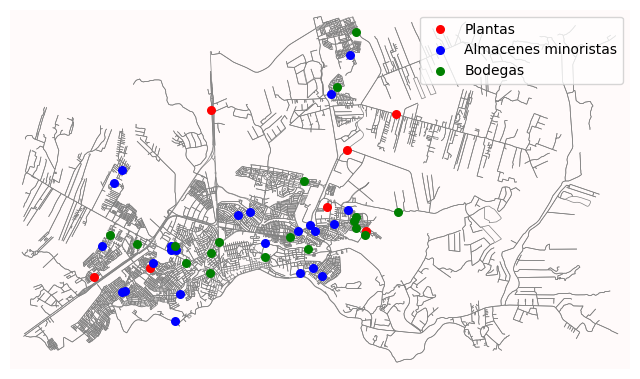

In [10]:
import matplotlib.pyplot as plt

fig, ax = ox.plot_graph(PM, node_size=0, edge_color="gray", edge_linewidth=0.5, bgcolor = 'snow', close=False, show=False)


ax.scatter([PM.nodes[node]['x'] for node in n_plantas],
           [PM.nodes[node]['y'] for node in n_plantas],
           c='red', s=30, label="Plantas")

ax.scatter([PM.nodes[node]['x'] for node in n_almacenes],
           [PM.nodes[node]['y'] for node in n_almacenes],
           c='blue', s=30, label="Almacenes minoristas")

ax.scatter([PM.nodes[node]['x'] for node in n_bodegas],
           [PM.nodes[node]['y'] for node in n_bodegas],
           c='green', s=30, label="Bodegas")

plt.legend(loc="upper right")
plt.show()

# Parte 0: Procesamiento

In [11]:
N = []
for a in range(len(nodos_totales)):
    lista = nodos_totales.loc[a].to_list()
    nodo = funciones.Node(lista[0], lista[1], lista[2], lista[3], lista[4])
    N.append(nodo)

# DICCIONARIO DE ID EN EL MAPA Y EL ID QUE LE PUSE A LOS NODOS

ids = nodos_totales['id_nodo'].to_list()
nombres = nodos_totales['id'].to_list()

dict_ids_nombres = {}

for a in range(len(ids)):
    dict_ids_nombres[ids[a]] = nombres[a]

for a in range(1,parametros.P+1):
    nombres.append(f'PB{a}')

In [12]:
# Como se especifica que el transporte es desde los nodos de produccion a bodegas y demanda, y de los nodos
# de bodega  a los nodos de demanda, elimino los arcos que no sirven para del grafo de todos los nodos conectados entre si.

# list(grafo_vial.edges(data=True))[par][origen/destino]
grafo_vial_nuevo = grafo_vial.copy()
lista_pares_nodos = list(grafo_vial_nuevo.edges())

for b in range(len(lista_pares_nodos)):
    a = lista_pares_nodos[b]
    
    O = nodos_totales[nodos_totales['id_nodo'] == a[0]]
    O_pos = O.index[0]

    D = nodos_totales[nodos_totales['id_nodo'] == a[1]]
    D_pos = D.index[0]

    if O['tipo'][O_pos] == D['tipo'][D_pos]:
        grafo_vial_nuevo.remove_edge(O['id_nodo'][O_pos],D['id_nodo'][D_pos])
    
    elif O['tipo'][O_pos] == 'demanda':
        grafo_vial_nuevo.remove_edge(O['id_nodo'][O_pos], D['id_nodo'][D_pos])

info_tipo_nodo = list(dict(grafo_vial_nuevo.nodes(data=True)).values())

In [13]:
# Las rutas minimas entre los nodos (todo el grafo se demora 1 min aprox)
r_min = funciones.rutas_min(grafo_vial_nuevo, parametros.G, len(list(grafo_vial_nuevo.edges())))
#graficar_rutas_min_n(r_min[0], G, 100)

In [14]:
# matriz de costos con las distancias entre los nodos en el mapa
matriz_costos = []
lista_arcos = list(grafo_vial_nuevo.edges(data=True))

for a in range(len(r_min[0])):
    matriz_costos.append([dict_ids_nombres[lista_arcos[a][0]],
                         dict_ids_nombres[lista_arcos[a][1]],
                         r_min[1][a],
                         r_min[0][a]])

In [15]:
matriz_costos_prod_dem = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])
matriz_costos_prod_bod = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])
matriz_costos_bod_dem = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])

for a in matriz_costos:
    if 'P' in a[0]:
        if 'D' in a[1]:
            matriz_costos_prod_dem = matriz_costos_prod_dem._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)
        elif 'B' in a[1]:
            matriz_costos_prod_bod = matriz_costos_prod_bod._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)
    if 'B' in a[0]:
        matriz_costos_bod_dem = matriz_costos_bod_dem._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)

In [16]:
I = parametros.P
J = parametros.B + 1

# PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
columnas = list(nodos_bodegas.index)
filas = []
for a in range(1,I):
    columnas.append(a)
    filas.append(np.float64(0))
filas.append(np.float64(0))

dict_matriz = dict()
for b in range(0,J-1):
    dict_matriz[columnas[b]] = filas

prod_bodega = pd.DataFrame(data = dict_matriz)


prod_bodega['id'] = list(nodos_produccion.index)

prod_bodega = prod_bodega.set_index('id')

for i in range(len(matriz_costos_prod_bod)):
    fila = matriz_costos_prod_bod.loc[i]['origen']
    columna = matriz_costos_prod_bod.loc[i]['destino']
    guardar = matriz_costos_prod_bod.loc[i]['distancia']
    prod_bodega.loc[fila][columna] = guardar

In [17]:
I = parametros.P
J = parametros.D + 1

# PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
columnas = list(nodos_demanda.index)
filas = []
for a in range(1,I):
    columnas.append(a)
    filas.append(np.float64(0))
filas.append(np.float64(0))

dict_matriz = dict()
for b in range(0,J-1):
    dict_matriz[columnas[b]] = filas

prod_demanda = pd.DataFrame(data = dict_matriz)


prod_demanda['id'] = list(nodos_produccion.index)

prod_demanda = prod_demanda.set_index('id')

for i in range(len(matriz_costos_prod_dem)):
    fila = matriz_costos_prod_dem.loc[i]['origen']
    columna = matriz_costos_prod_dem.loc[i]['destino']
    guardar = matriz_costos_prod_dem.loc[i]['distancia']
    prod_demanda.loc[fila][columna] = guardar


In [18]:
I = parametros.B
J = parametros.D + 1

# PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
columnas = list(nodos_demanda.index)
filas = []
for a in range(1,I):
    columnas.append(a)
    filas.append(np.float64(0))
filas.append(np.float64(0))

dict_matriz = dict()
for b in range(0,J-1):
    dict_matriz[columnas[b]] = filas

bod_demanda = pd.DataFrame(data = dict_matriz)


bod_demanda['id'] = list(nodos_bodegas.index)

bod_demanda = bod_demanda.set_index('id')

for i in range(len(matriz_costos_bod_dem)):
    fila = matriz_costos_bod_dem.loc[i]['origen']
    columna = matriz_costos_bod_dem.loc[i]['destino']
    guardar = matriz_costos_bod_dem.loc[i]['distancia']
    bod_demanda.loc[fila][columna] = guardar

In [19]:
prod_demanda_distancias = prod_demanda
prod_demanda = round((prod_demanda / 1000) * 12)

prod_bodega_distancias = prod_bodega
prod_bodega = round((prod_bodega / 1000) * 12)

bod_demanda_distancias = bod_demanda
bod_demanda = round((bod_demanda / 1000) * 12)

# Parte I

## Construcción del grafo

In [20]:
G1 = nx.DiGraph()

### Nodos

In [21]:
#se agregan los nodos correspondientes a las tiendas

entra = 0
sale = 0

for d in range(1, parametros.D+1):
  for t in range(1, parametros.T+1):
    nombre_nodo = 'D' + str(d) + ', t' + str(t)
    demanda = (demanda_max.loc[f'D{d}'][f'{t}'] - demanda_min.loc[f'D{d}'][f'{t}'])
    sale += demanda
    G1.add_node(nombre_nodo, demand = demanda)

In [22]:
#se agregan los nodos correspondientes a las fábricas

for p in range(1, parametros.P+1):
  for t in range(1, parametros.T):
    nombre_nodo = 'P' + str(p) + ', t' + str(t)
    oferta = (oferta_max_proveedores.loc[f'P{p}'][f'{t}'] - oferta_min_proveedores.loc[f'P{p}'][f'{t}'])
    entra += oferta
    G1.add_node(nombre_nodo, demand = -oferta)

In [23]:
inv_inicial_fabricas = inventario_inicial.to_dict()['1']
inv_inicial_bodegas = inventario_inicial_adicional.to_dict()['1']

In [24]:
#se agregan los nodos correspondientes a las bodegas de las fábricas

inv_0_fabricas = 0

for i in range(1, parametros.P + 1):
  for j in range(1, parametros.T + 1):
    nombre_nodo = 'P_bodega' + str(i) + ', t' + str(j)
    if j == 1:
      oferta = inv_inicial_fabricas[f'P{i}']
      inv_0_fabricas += oferta
      G1.add_node(nombre_nodo, demand = -oferta)
    else:
      G1.add_node(nombre_nodo)

In [25]:
#se agregan los nodos de bodegas adicionales
inv_0_bodegas = 0

for i in range(1, parametros.B+1):
  for j in range(1, parametros.T+1):
    nombre_nodo = 'B' + str(i) + ', t' + str(j)
    if j == 1:
      oferta = inv_inicial_bodegas[f'B{i}']
      inv_0_bodegas += oferta
      G1.add_node(nombre_nodo, demand = -oferta)
    else:
      G1.add_node(nombre_nodo)

In [26]:
#se agregan nodos auxiliares para todas las bodegas, tanto de fábricas como bodegas adicionales

for p in range(1, parametros.P + 1):
  for j in range(1, parametros.T +1):
    nombre_nodo = 'P_aux' + str(i) + ', t' + str(j)
    G1.add_node(nombre_nodo)

for i in range(1, parametros.B + 1):
  for j in range(1, parametros.T+1):
    nombre_nodo = 'B_aux' + str(i) + ', t' + str(j)
    G1.add_node(nombre_nodo)

In [27]:
# vemos cuanto falta para balancear la demanda
suma=0
for a in list(G1.nodes(data=True)):
    if len(a[1])>0:
        suma += a[1]['demand']
print(suma)

-24096


In [28]:
G1.add_node('Sumidero', demand = -suma)

In [29]:
# verificamos que la demanda esta balanceada
suma=0
for a in list(G1.nodes(data=True)):
    if len(a[1])>0:
        suma += a[1]['demand']
print(suma)

0


### Arcos

In [30]:
#se añaden los arcos desde cada fábrica a su nodo auxiliar en todos los periodos

for t in range(1, parametros.T):
  for i in range(1, parametros.P + 1):
      nombrefab = 'P' + str(i) + ', t' + str(t)
      nombreaux = 'P_aux' + str(i) + ', t' + str(t)
      costo_prod = costo_produccion.loc[f'P{i}'][f'{t}']
      G1.add_edge(nombrefab, nombreaux, weight = costo_prod)


In [31]:
#se agregan los arcos desde cada bodega de fábrica hasta cada tienda en todos los periodos

for t in range(1, parametros.T + 1):
  for b in range(1, parametros.P + 1):
    for s in range(1, parametros.D +1):
      costo_trans = prod_demanda.loc[f'P{b}'][f'D{s}']
      p_venta = precio_venta[f'{t}'][f'D{s}']

      nombrebod = 'P_bodega' + str(b) + ', t' + str(t)
      nombretienda = 'D' + str(s) + ', t' + str(t)
      G1.add_edge(nombrebod, nombretienda, weight = costo_trans-p_venta)

In [32]:
#agregamos el arco que une cada bodega de fábrica con el nodo auxiliar de esa fábrica del mismo periodo

for t in range(1, parametros.T+1):
  for b in range(1, parametros.P+1):
    nombrebod = 'P_bodega' + str(b) + ', t' + str(t)
    nombreaux = 'P_aux' + str(b) + ', t' + str(t)
    G1.add_edge(nombrebod, nombreaux, weight = 0)

In [33]:
#agregamos los arcos que unen el nodo auxiliar de la bodega de una fábrica con el nodo de la misma bodega pero
#en el periodo siguiente

for t in range(1, parametros.T):
  for b in range(1, parametros.P + 1):
    nombreaux = 'P_aux' + str(b) + ', t' + str(t)
    nombrebod = 'P_bodega' + str(b) + ', t' + str(t + 1)
    c_almacenaje = costo_almacenaje.loc[f'P{b}'][f'{t}']
    capacidad_max = capacidad_almacenaje.loc[f'P{b}'][f'{t}']
    G1.add_edge(nombreaux, nombrebod, weight = c_almacenaje, capacity = capacidad_max)

In [34]:
#agregamos arcos desde bodegas de fabricas hasta auxiliares de bodegas adicionales del mismo periodo

for t in range(1, parametros.T+1):
  for b in range(1, parametros.P +1):
    for a in range(1, parametros.B + 1):
      nombrebod = 'P_bodega' + str(b) + ', t' + str(t)
      nombreauxad = 'B_aux' + str(a) + ', t' + str(t)
      costo_trans = prod_bodega.loc[f'P{b}'][f'B{a}']
      G1.add_edge(nombrebod, nombreauxad, weight = costo_trans)

In [35]:
#agregamos arcos  desde nodos auxiliares de bodegas adicionales hasta la misma bodega en el siguiente periodo, para
#todos los periodos y todas las bodegas

for t in range(1, parametros.T):
  for a in range(1, parametros.B + 1):
    nombreauxad = 'B_aux' + str(a) + ', t' + str(t)
    nombrebodad = 'B' + str(a) + ', t' + str(t + 1)
    c_almacenaje = costo_almacenaje_adicional.loc[f'B{b}'][f'{t}']
    capacidad_max = capacidad_almacenaje_adicional.loc[f'B{b}'][f'{t}']
    G1.add_edge(nombreauxad, nombrebodad, weight = c_almacenaje, capacity = capacidad_max)

In [36]:
#agregamos el arco que une cada bodega adicional con el nodo auxiliar de esa bodega adicional del mismo periodo

for t in range(1, parametros.T+1):
  for a in range(1, parametros.B +1 ):
    nombrebodad = 'B' + str(a) + ', t' + str(t)
    nombreauxad = 'B_aux' + str(a) + ', t' + str(t)
    G1.add_edge(nombrebodad, nombreauxad, weight = 0)

In [37]:
#agregamos arcos que unen las bodegas adicionales con las tiendas para todos los periodos

for t in range(1, parametros.T +1):
  for s in range(1, parametros.D +1):
    for a in range(1, parametros.B +1):
      nombrebodad = 'B' + str(a) + ', t' + str(t)
      nombretienda = 'D' + str(s) + ', t' + str(t)

      costo_trans = bod_demanda.loc[f'B{a}'][f'D{s}']
      p_venta = precio_venta[f'{t}'][f'D{s}']

      G1.add_edge(nombrebodad, nombretienda, weight = costo_trans-p_venta)

In [38]:
#agregamos arcos desde fábricas hasta el sumidero para absorber el exceso de oferta

for t in range(1, parametros.T):
  for f in range(1, parametros.P + 1):
    nombrefab = 'P' + str(f) + ', t' + str(t)
    G1.add_edge(nombrefab, 'Sumidero', weight = 0)

In [39]:
#agregamos arcos desde el sumidero hasta las tiendas en caso de que no se cumpla la demanda

for t in range(1, parametros.T+1):
  for s in range(1, parametros.D+1):
    nombretienda = 'D' + str(s) + ', t' + str(t)
    G1.add_edge('Sumidero', nombretienda, weight = 0)

### Solución al problema

In [40]:
sol = nx.min_cost_flow(G1, demand='demand', capacity='capacity', weight='weight')

In [41]:
# Obtener el tipo de la variable
tipo = type(sol)
print(tipo)
sol

<class 'dict'>


{'D1, t1': {},
 'D1, t2': {},
 'D1, t3': {},
 'D1, t4': {},
 'D1, t5': {},
 'D1, t6': {},
 'D1, t7': {},
 'D1, t8': {},
 'D2, t1': {},
 'D2, t2': {},
 'D2, t3': {},
 'D2, t4': {},
 'D2, t5': {},
 'D2, t6': {},
 'D2, t7': {},
 'D2, t8': {},
 'D3, t1': {},
 'D3, t2': {},
 'D3, t3': {},
 'D3, t4': {},
 'D3, t5': {},
 'D3, t6': {},
 'D3, t7': {},
 'D3, t8': {},
 'D4, t1': {},
 'D4, t2': {},
 'D4, t3': {},
 'D4, t4': {},
 'D4, t5': {},
 'D4, t6': {},
 'D4, t7': {},
 'D4, t8': {},
 'D5, t1': {},
 'D5, t2': {},
 'D5, t3': {},
 'D5, t4': {},
 'D5, t5': {},
 'D5, t6': {},
 'D5, t7': {},
 'D5, t8': {},
 'D6, t1': {},
 'D6, t2': {},
 'D6, t3': {},
 'D6, t4': {},
 'D6, t5': {},
 'D6, t6': {},
 'D6, t7': {},
 'D6, t8': {},
 'D7, t1': {},
 'D7, t2': {},
 'D7, t3': {},
 'D7, t4': {},
 'D7, t5': {},
 'D7, t6': {},
 'D7, t7': {},
 'D7, t8': {},
 'D8, t1': {},
 'D8, t2': {},
 'D8, t3': {},
 'D8, t4': {},
 'D8, t5': {},
 'D8, t6': {},
 'D8, t7': {},
 'D8, t8': {},
 'D9, t1': {},
 'D9, t2': {},
 'D9, t3':

## Construcción de funciones

In [42]:
# Lista con todos los nodos (nombre) y los periodos de tiempo en formato 't...'
bodegas = list(nodos_bodegas.index)
fabricas = list(nodos_produccion.index)
tiendas = list(nodos_demanda.index)

dias = []
for t in range(1, parametros.T+1):
  dias.append('t' + str(t))

fabricas_bodegas = []
fabricas_aux = []
for i in range(1, parametros.P + 1):
  fabricas_bodegas.append('P_bodega' + str(i))
  fabricas_aux.append('P_aux' + str(i))

bodegas_aux = []
for i in range(1, parametros.B + 1):
  fabricas_bodegas.append('B_aux' + str(i))

#### Funcion 1

Construcción de una función que reciba como argumentos un periodo de tiempo, y que 
entregue un gráfico que muestre las plantas, bodegas y minoristas, y que ilustre las rutas 
y cargas transportadas entre estos nodos. Si además esta gráfica muestra niveles de 
inventario inicial y final en cada nodo, el grupo recibirá una bonificación.

In [43]:
# Crear el diccionario flujos_totales basado en la estructura de sol y los nombres de nodos específicos
flujos_totales = {}

for t in range(1, 9):  # Ajusta los periodos según tus necesidades
    flujos_periodo = {}
    for nodo_origen, subflujos in sol.items():
        # Verificar que el nodo esté en el formato correcto y en el periodo deseado
        if ', t' in nodo_origen and int(nodo_origen.split(', t')[-1]) == t:
            for nodo_destino, flujo in subflujos.items():
                if flujo != 0:
                    # Asignar el origen y destino según los nombres de nodos específicos
                    if nodo_origen.startswith("P_aux"):
                        origen = f"fabrica{nodo_origen[-1]}"
                    elif nodo_origen.startswith("P_bodega"):
                        origen = f"bodega{nodo_origen[-1]}"
                    elif nodo_origen.startswith("P"):
                        origen = f"planta{nodo_origen[-1]}"
                    elif nodo_origen.startswith("B_aux"):
                        origen = f"bodega_aux{nodo_origen[-1]}"
                    elif nodo_origen.startswith("D"):
                        origen = f"almacen{nodo_origen[-1]}"

                    # Asignar el destino de manera similar
                    if nodo_destino.startswith("P_aux"):
                        destino = f"fabrica{nodo_destino[-1]}"
                    elif nodo_destino.startswith("P_bodega"):
                        destino = f"bodega{nodo_destino[-1]}"
                    elif nodo_destino.startswith("P"):
                        destino = f"planta{nodo_destino[-1]}"
                    elif nodo_destino.startswith("B_aux"):
                        destino = f"bodega_aux{nodo_destino[-1]}"
                    elif nodo_destino.startswith("D"):
                        destino = f"almacen{nodo_destino[-1]}"
                    
                    # Crear el arco y asignar el flujo
                    arco = (origen, destino)
                    flujos_periodo[arco] = flujo
    flujos_totales[t] = flujos_periodo



In [44]:
# Definir el diccionario de mapeo para los nodos
mapeo = {}
for i in range(len(n_plantas)):
    mapeo[n_plantas[i]] = plantas[i]

for i in range(len(n_almacenes)):
    mapeo[n_almacenes[i]] = almacenes[i]

for i in range(len(n_bodegas)):
    mapeo[n_bodegas[i]] = bodegas[i]

# Relabelar los nodos en PM
PM = nx.relabel_nodes(PM, mapeo)
mapeo

{10827367167: 'planta1',
 7564594729: 'planta2',
 12119644005: 'planta3',
 475560866: 'planta4',
 1143298979: 'planta5',
 3723703649: 'planta6',
 1853718397: 'planta7',
 9261244985: 'almacén1',
 265016378: 'almacén2',
 7832735376: 'almacén3',
 1886717431: 'almacén4',
 455782369: 'almacén5',
 476023196: 'almacén6',
 9569434781: 'almacén7',
 475560947: 'almacén8',
 6107982164: 'almacén9',
 475560777: 'almacén10',
 267183037: 'almacén11',
 266902436: 'almacén12',
 267182640: 'almacén13',
 476023935: 'almacén14',
 267456834: 'almacén15',
 262503262: 'almacén16',
 8856840317: 'almacén17',
 266105475: 'almacén18',
 1784870488: 'almacén19',
 1840721441: 'almacén20',
 3663848976: 'almacén21',
 266907565: 'almacén22',
 476023188: 'almacén23',
 1886787603: 'almacén24',
 1784870456: 'B1',
 267187616: 'B2',
 1886717444: 'B3',
 321004778: 'B4',
 1893185450: 'B5',
 9476649431: 'B6',
 265325294: 'B7',
 265742684: 'B8',
 9231325097: 'B9',
 3666343193: 'B10',
 4477723612: 'B11',
 3674253932: 'B12',
 44

In [45]:
print("Nodos en PM:", PM.nodes)


Nodos en PM: [180162699, 180162703, 180162713, 180162717, 251876819, 251876829, 251876836, 251876845, 251876848, 251876853, 251876859, 251876860, 251876864, 251876865, 251876867, 251876869, 262241063, 262432783, 262432784, 262432785, 262432786, 262432787, 262432789, 262432790, 262432791, 262432792, 262432793, 262432794, 262432795, 262432796, 262432797, 262432798, 262432799, 262432802, 262432803, 262432804, 262432805, 262432806, 262432807, 262432808, 262432809, 262432810, 262432811, 262432812, 262432814, 262432815, 262432816, 262432817, 262433915, 262433916, 262433917, 262433918, 262433919, 262433920, 262433921, 262433922, 262433923, 262433924, 262433925, 262433926, 262433927, 262433928, 262433929, 262433930, 262433931, 262433936, 262433940, 262433942, 262433946, 262433952, 262433955, 262433958, 262433962, 262433967, 262433971, 262433980, 262433984, 262433988, 262433992, 262433998, 262434007, 262434014, 262434015, 262434016, 262434022, 262434023, 262434024, 262434025, 262434026, 2624340

NO entra al if
Nodo planta3 o bodega3 no encontrado en el grafo
NO entra al if
Nodo planta3 o fabrica3 no encontrado en el grafo
NO entra al if
Nodo bodega3 o almacen3 no encontrado en el grafo
NO entra al if
Nodo fabrica3 o bodega4 no encontrado en el grafo


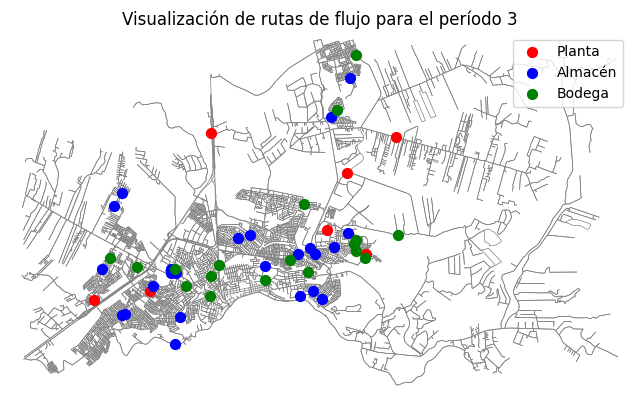

In [46]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox

def visualizar_flujo_periodo(G, periodo, datos_de_flujo):
    if periodo not in datos_de_flujo:
        print(f"No se encontraron datos de flujo para el período {periodo}")
        return

    flujos_para_periodo = datos_de_flujo[periodo]

    #dibujar el gráfico
    fig, ax = ox.plot_graph(G, node_size=0, edge_color="gray", edge_linewidth=0.5, bgcolor='snow', close=False, show=False)

    #nodos según su tipo
    ax.scatter([G.nodes[node]['x'] for node in plantas],
               [G.nodes[node]['y'] for node in plantas],
               c='red', s=50, label="Planta")

    ax.scatter([G.nodes[node]['x'] for node in almacenes],
               [G.nodes[node]['y'] for node in almacenes],
               c='blue', s=50, label="Almacén")

    ax.scatter([G.nodes[node]['x'] for node in bodegas],
               [G.nodes[node]['y'] for node in bodegas],
               c='green', s=50, label="Bodega")

    for arista, cantidad_de_flujo in flujos_para_periodo.items():
        nodo_fuente, nodo_objetivo = arista
        print("NO entra al if")
        if nodo_fuente in G and nodo_objetivo in G:
            #calcular el camino más corto entre el nodo fuente y el objetivo
            camino_mas_corto = nx.shortest_path(G, source=nodo_fuente, target=nodo_objetivo, weight='length')
            print("El camino mas corto es:")
            print(camino_mas_corto)

            #coordenadas de los nodos en el camino más corto
            coordenadas_del_camino = [(G.nodes[nodo]['x'], G.nodes[nodo]['y']) for nodo in camino_mas_corto]

            #crear una línea que conecte los nodos con un ancho basado en la cantidad de flujo con color
            x, y = zip(*coordenadas_del_camino)
            if cantidad_de_flujo <= 500:
                ancho_de_linea = 1.5
                ax.plot(x, y, linewidth=ancho_de_linea, color='orange')
            elif cantidad_de_flujo <= 1000:
                ancho_de_linea = 2
                ax.plot(x, y, linewidth=ancho_de_linea, color='magenta')
            else:
                ancho_de_linea = 2.5
                ax.plot(x, y, linewidth=ancho_de_linea, color='yellow')
        else:
            print(f"Nodo {nodo_fuente} o {nodo_objetivo} no encontrado en el grafo")

    plt.title(f"Visualización de rutas de flujo para el período {periodo}")
    plt.axis('off')
    plt.legend(loc="upper right")
    plt.show()

#probando
visualizar_flujo_periodo(PM, 3, flujos_totales)


#### funcion 2

Construir una función que reciba como argumentos una bodega, y que entregue la 
evolución de su nivel de inventario. Esta función también debe permitir hacer este 
análisis en forma agregada para el sistema (es decir, sumado para todas las bodegas)

In [47]:
def preprosecesamiento_funcion2(solucion: dict):
    # creo una matriz con ceros para actualizarla segun el inventario
    I = parametros.B
    J = parametros.T + 1

    # PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
    columnas = list(list(range(1,parametros.T + 1)))
    filas = []
    for a in range(1,I):
        columnas.append(a)
        filas.append(np.float64(0))
    filas.append(np.float64(0))

    dict_matriz = dict()
    for b in range(0,J-1):
        dict_matriz[columnas[b]] = filas

    ppp = pd.DataFrame(data = dict_matriz)
    ppp['id'] = list(nodos_bodegas.index)

    ppp = ppp.set_index('id')

    # al dia 1 le pongo el inventario inicial
    ppp[1] = inventario_inicial_adicional['1']


    for a in range(1, 9):
        num_dia = a
        if num_dia == 8:
            dia_actual = dias[num_dia-1]

        else:
            dia_actual = dias[num_dia-1]
            dia_siguiente = dias[num_dia]

        sol_1 = {}

    # saco de sol los nodos que no envian flujo, pongo los nodos que si envian algo en una nuevo diccionario

        for nodo_origen in list(solucion.keys()):
            if dia_actual in nodo_origen:
                if len(solucion[nodo_origen]) != 0:
                    sol_1[nodo_origen] = solucion[nodo_origen]
        sol_2 = {}
        for nodo_origen in list(sol_1.keys()):
            sol_2[nodo_origen] = {}
            for nodo_destino in sol_1[nodo_origen]:
                if sol_1[nodo_origen][nodo_destino] != 0:
                    sol_2[nodo_origen][nodo_destino] = sol_1[nodo_origen][nodo_destino]

        for nodo_origen in (list(sol_2.keys())):
            if 'B_aux' in nodo_origen:
                for nodo_destino in (list(sol_2[nodo_origen].keys())):
                    if dia_siguiente in nodo_destino:
                        que_nodo_origen = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                        cantidad = sol_2[nodo_origen][nodo_destino]
                        ppp[num_dia+1][f'B{que_nodo_origen}'] = cantidad
                        
                        #print(f'Bodega {que_nodo_origen} guarda {cantidad} dulces para el día {num_dia+1}.')
    return ppp

In [48]:
def nivel_bodegas(num_bodega: int, matriz_inventarios: pd.DataFrame):
    if num_bodega == 0:
        print('     Día    |       Inventario')
        print('___________________________________')
        for a in matriz_inventarios:
            print(f'''      {a}     |       {int(matriz_inventarios.sum()[a])} dulces''')
        return list(matriz_inventarios.sum())

    bodega = f'B{num_bodega}'
    if bodega not in list(matriz_inventarios.index):
        print('No existe ese número de bodega')
    
    else:
        print('     Día    |       Inventario')
        print('___________________________________')
        for a in matriz_inventarios:
            print(f'''      {a}     |       {int(matriz_inventarios.loc[bodega][a])} dulces''')
        return list(matriz_inventarios.loc[bodega])


In [49]:
# EJECUTAR ESTA CELDA PARA REVISAR UNA BODEGA ADICIONAL
num_bodega = 9      # elegir aqui que numero de bodega revisar, si se quieren todas, poner 0

matriz_inv = preprosecesamiento_funcion2(sol)
nivel_bodegas(num_bodega, matriz_inv)

     Día    |       Inventario
___________________________________
      1     |       30 dulces
      2     |       0 dulces
      3     |       0 dulces
      4     |       0 dulces
      5     |       0 dulces
      6     |       0 dulces
      7     |       0 dulces
      8     |       0 dulces


[30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

#### funcion 3

Construir  una  función  que  construya  un  reporte  de  operación  diaria,  que  indique 
claramente el plan operativo del día, en un formato que podría ser fácilmente entendido 
por el personal responsable de ejecutar las instrucciones.

In [50]:
def imprimir_programacion(num_dia: int):
    if num_dia > 8:
        print('Día fuera del periodo productivo.')

    elif num_dia == 8:
        dia_actual = dias[num_dia-1]
        día_siguiente = dia_actual

    else:
        dia_actual = dias[num_dia-1]
        dia_siguiente = dias[num_dia]

    sol_1 = {}

    # saco de sol los nodos que no envian flujo, pongo los nodos que si envian algo en una nuevo diccionario

    for nodo_origen in list(sol.keys()):
        if dia_actual in nodo_origen:
            if len(sol[nodo_origen]) != 0:
                sol_1[nodo_origen] = sol[nodo_origen]

    sol_2 = {}
    for nodo_origen in list(sol_1.keys()):
        sol_2[nodo_origen] = {}
        for nodo_destino in sol_1[nodo_origen]:
            if sol_1[nodo_origen][nodo_destino] != 0:
                sol_2[nodo_origen][nodo_destino] = sol_1[nodo_origen][nodo_destino]

    # imprimo el tipo de nodo de origen desde el que envio

    for nodo_origen in (list(sol_2.keys())):
        if 'P_aux' not in nodo_origen and 'P_bod' not in nodo_origen and 'P' in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                if 'P_aux' in nodo_destino:
                    que_nodo = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Fábrica {que_nodo} produce {cantidad} dulces.')

        if 'P_bodega' in nodo_origen:        
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                que_nodo_origen = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                que_nodo_destino = funciones.extraer_numeros(nodo_destino.split(',')[0])[0]

                cantidad = sol_2[nodo_origen][nodo_destino]
                if 'D' in nodo_destino:
                    print(f'Fábrica {que_nodo_origen} envia {cantidad} dulces a la casa {que_nodo_destino}.')
                
                if 'B' in nodo_destino:
                    print(f'Fábrica {que_nodo_origen} envia {cantidad} dulces a la bodega {que_nodo_destino}.')
        
        if 'P_aux' in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):            
                if dia_siguiente in nodo_destino:
                    que_nodo_origen = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                    que_nodo_destino = funciones.extraer_numeros(nodo_destino.split(',')[0])[0]
                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Fábrica {que_nodo_origen} guarda {cantidad} dulces para el dia siguiente.')
        
        if 'B' in nodo_origen and 'B_aux' not in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                if 'D' in nodo_destino:
                    que_nodo_origen = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                    que_nodo_destino = funciones.extraer_numeros(nodo_destino.split(',')[0])[0]

                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Bodega {que_nodo_origen} envia {cantidad} dulces a la casa {que_nodo_destino}.')
        
        if 'B_aux' in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                if dia_siguiente in nodo_destino:
                    que_nodo_origen = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                    que_nodo_destino = funciones.extraer_numeros(nodo_destino.split(',')[0])[0]

                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Bodega {que_nodo_origen} guarda {cantidad} dulces para el día siguiente.')

In [51]:
imprimir_programacion(6)

Fábrica 2 produce 1046 dulces.
Fábrica 3 produce 1204 dulces.
Fábrica 4 produce 1150 dulces.
Fábrica 6 produce 1000 dulces.
Fábrica 7 produce 1054 dulces.
Fábrica 2 envia 400 dulces a la casa 1.
Fábrica 2 envia 200 dulces a la casa 5.
Fábrica 2 envia 300 dulces a la casa 11.
Fábrica 2 envia 300 dulces a la casa 13.
Fábrica 2 envia 141 dulces a la casa 18.
Fábrica 3 envia 48 dulces a la casa 3.
Fábrica 3 envia 53 dulces a la casa 10.
Fábrica 3 envia 200 dulces a la casa 17.
Fábrica 3 envia 300 dulces a la casa 19.
Fábrica 3 envia 400 dulces a la casa 20.
Fábrica 3 envia 200 dulces a la casa 23.
Fábrica 4 envia 300 dulces a la casa 8.
Fábrica 4 envia 347 dulces a la casa 10.
Fábrica 4 envia 300 dulces a la casa 14.
Fábrica 4 envia 200 dulces a la casa 15.
Fábrica 5 envia 300 dulces a la casa 4.
Fábrica 6 envia 400 dulces a la casa 2.
Fábrica 6 envia 217 dulces a la casa 12.
Fábrica 6 envia 300 dulces a la casa 16.
Fábrica 6 envia 200 dulces a la casa 21.
Fábrica 6 envia 300 dulces a la c

### Otros

In [52]:
# me dice la demanda q el sumidero esta supliendo
for a in sol['Sumidero'].keys():
    if sol['Sumidero'][a] !=0:
        print(a,sol['Sumidero'][a])

D2, t1 400
D3, t1 300
D5, t1 205
D6, t1 400
D7, t1 300
D13, t1 200
D14, t1 246
D17, t1 193
D18, t1 301
D20, t1 201
D24, t1 300
D2, t2 300
D3, t2 300
D5, t2 200
D6, t2 300
D7, t2 300
D13, t2 200
D14, t2 257
D20, t2 200
D2, t3 300
D3, t3 200
D5, t3 400
D6, t3 300
D7, t3 400
D14, t3 300
D2, t4 200
D3, t4 289
D5, t4 164
D6, t4 300
D14, t4 288
D3, t5 255
D6, t5 246
D3, t6 252
D6, t6 300
D2, t7 300
D3, t7 300
D5, t7 300
D6, t7 300
D7, t7 400
D14, t7 300
D20, t7 246
D2, t8 200
D3, t8 148
D5, t8 148
D6, t8 249
D7, t8 148
D14, t8 248


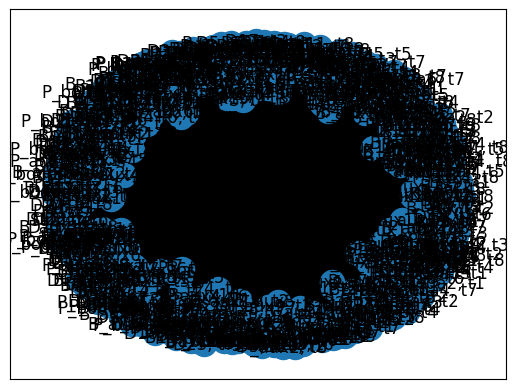

In [53]:
nx.draw_networkx(G1)

# Parte II: Análisis